In [1]:
import numpy as np
import matplotlib.pyplot as plt

from abtem import GridScan, PixelatedDetector, Potential, Probe, show_atoms, SMatrix, AnnularDetector, FrozenPhonons
from abtem.reconstruct import epie
from abtem.detect import FlexibleAnnularDetector
from abtem.transfer import CTF, scherzer_defocus
from ase.build import mx2
from abtem.structures import orthogonalize_cell
from abtem.measure import bandlimit

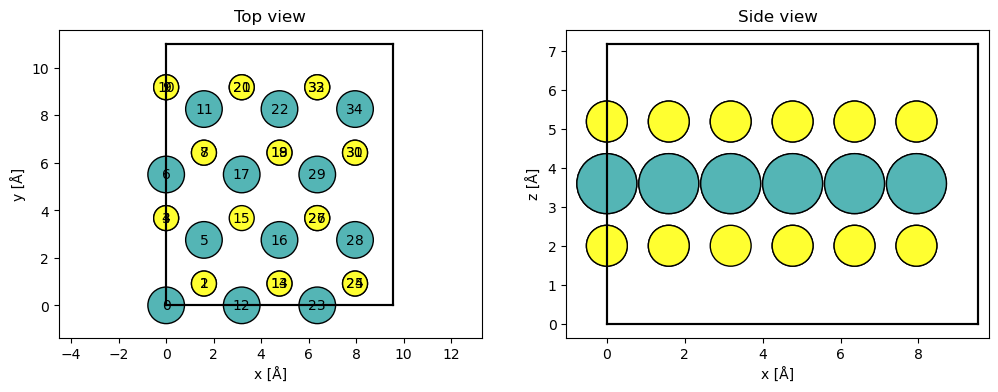

In [2]:
atoms = mx2(formula='MoS2', kind='2H', a=3.18, thickness=3.19, size=(1, 1, 1), vacuum=None)
atoms = orthogonalize_cell(atoms)
atoms.center(vacuum=2, axis=2)

atoms *= (3,2,1)
del atoms[16]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view', numbering=True)
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')
plt.show()

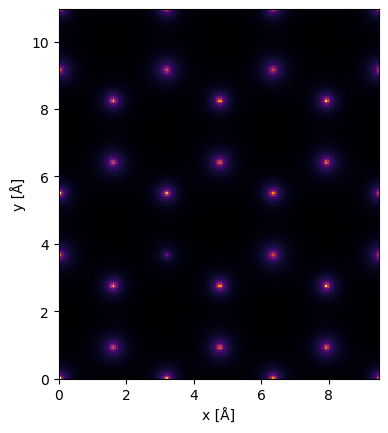

In [3]:
potential = Potential(atoms, 
                      sampling=.05,
                      projection='infinite', 
                      slice_thickness=1, 
                      parametrization='kirkland').build()
potential.project().show(cmap="inferno")
plt.show()

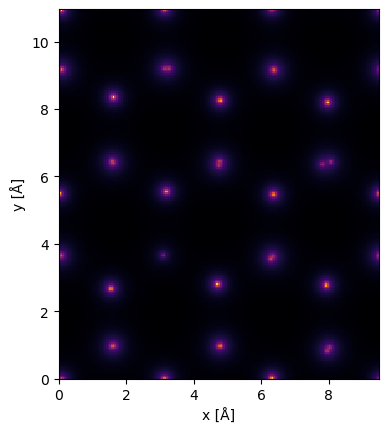

In [6]:
frozen_phonons = FrozenPhonons(atoms, 64, {"Mo":0.05, "S":0.05}, seed=56)
tds_potential = Potential(frozen_phonons, 
                      sampling=.05,
                      projection='infinite', 
                      slice_thickness=1, 
                      parametrization='kirkland').build()
tds_potential.project().show(cmap="inferno")
plt.show()

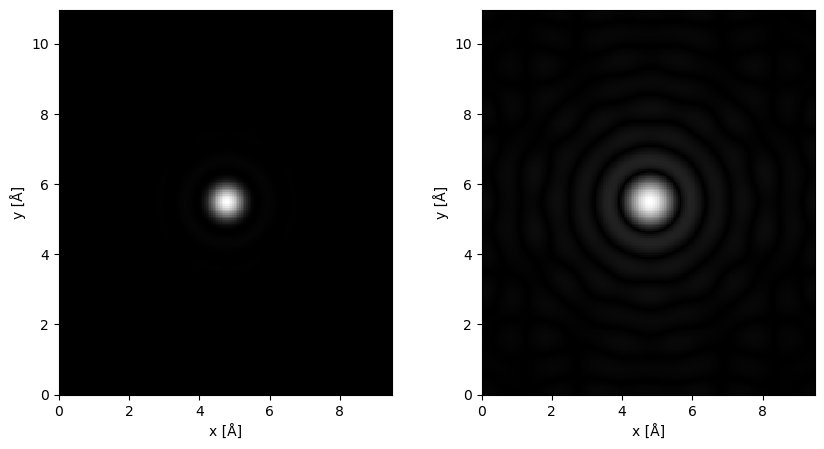

In [15]:
S = SMatrix(semiangle_cutoff=30, energy=80e3, expansion_cutoff=30, device='gpu')
S.grid.match(tds_potential)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
S.show(ax=axes[0])
S.show(ax=axes[1], power=0.5)
plt.show()

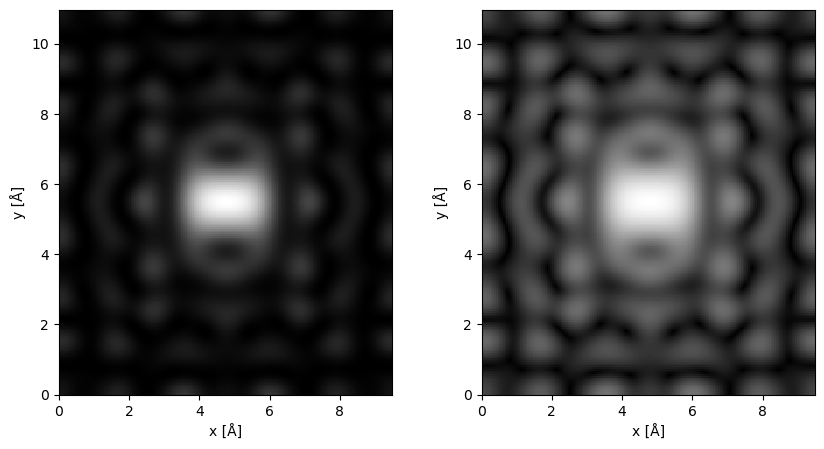

In [16]:
custom_ctf = CTF(semiangle_cutoff=30, energy=80E3, Cs=1E6, focal_spread=50)
S.ctf = custom_ctf
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
S.show(ax=axes[0])
S.show(ax=axes[1], power=0.5)
plt.show()

250.27133444991352


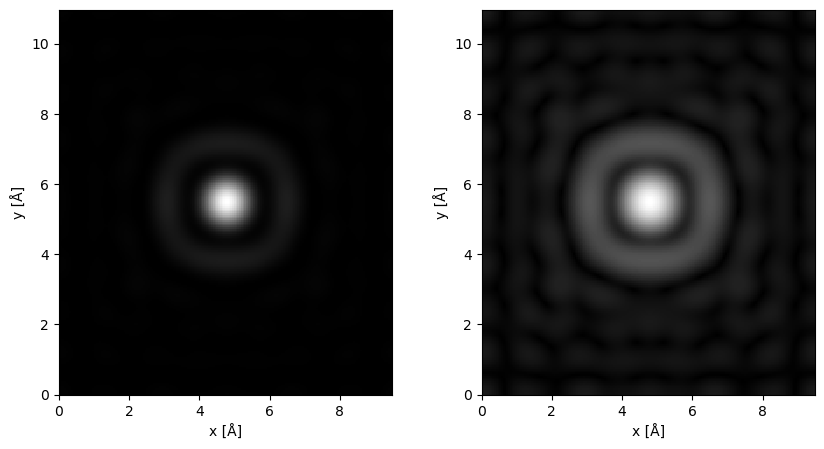

In [17]:
sch_defocus = scherzer_defocus(1E6, custom_ctf.energy)
print(sch_defocus)
custom_ctf.defocus = sch_defocus
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
S.show(ax=axes[0])
S.show(ax=axes[1], power=0.5)
plt.show()

In [18]:
print("Nyquist sampling", S.ctf.nyquist_sampling)

Nyquist sampling 0.34797633804078043


In [19]:
gridscan = GridScan((0,0), np.array(tds_potential.extent), sampling=0.4)
detector = PixelatedDetector()
measurement = S.scan(gridscan, [detector], tds_potential)

Multislice:   0%|          | 0/167 [00:00<?, ?it/s]

Scan:   0%|          | 0/672 [00:00<?, ?it/s]

In [20]:
flexible_measurement = S.scan(gridscan, FlexibleAnnularDetector(step_size=10), tds_potential)

Multislice:   0%|          | 0/167 [00:00<?, ?it/s]

Scan:   0%|          | 0/672 [00:00<?, ?it/s]

/home/jinseuk56/anaconda3/envs/ptycho/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


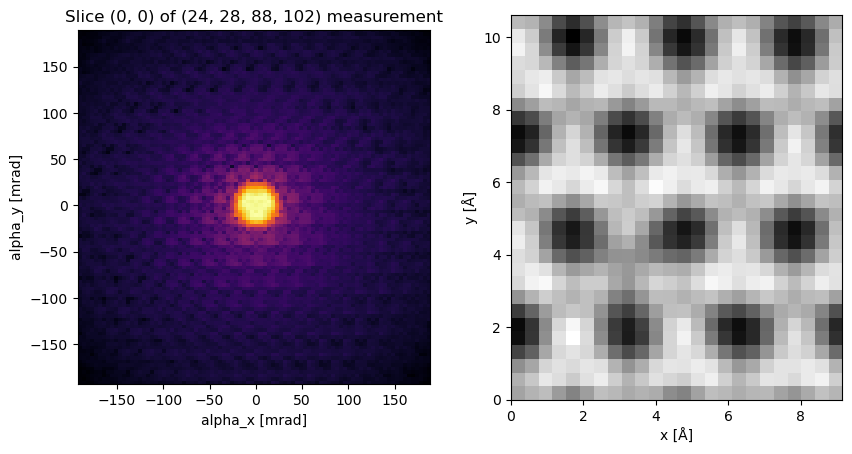

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
measurement.show(ax=axes[0], cmap="inferno", power=0.2)
flexible_measurement.integrate(10, 30).show(ax=axes[1])
plt.show()

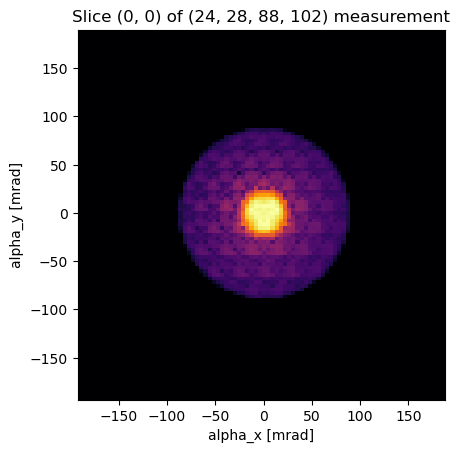

In [24]:
band_limited_measurment = bandlimit(measurement, 90)
band_limited_measurment.show(cmap="inferno", power=0.2)
plt.show()

In [26]:
probe_guess = Probe(semiangle_cutoff=30, energy=80e3)
reconstructions_full = epie(band_limited_measurment, probe_guess, maxiter=20, return_iterations=True, fix_com=True, device="gpu")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/672 [00:00<?, ?it/s]

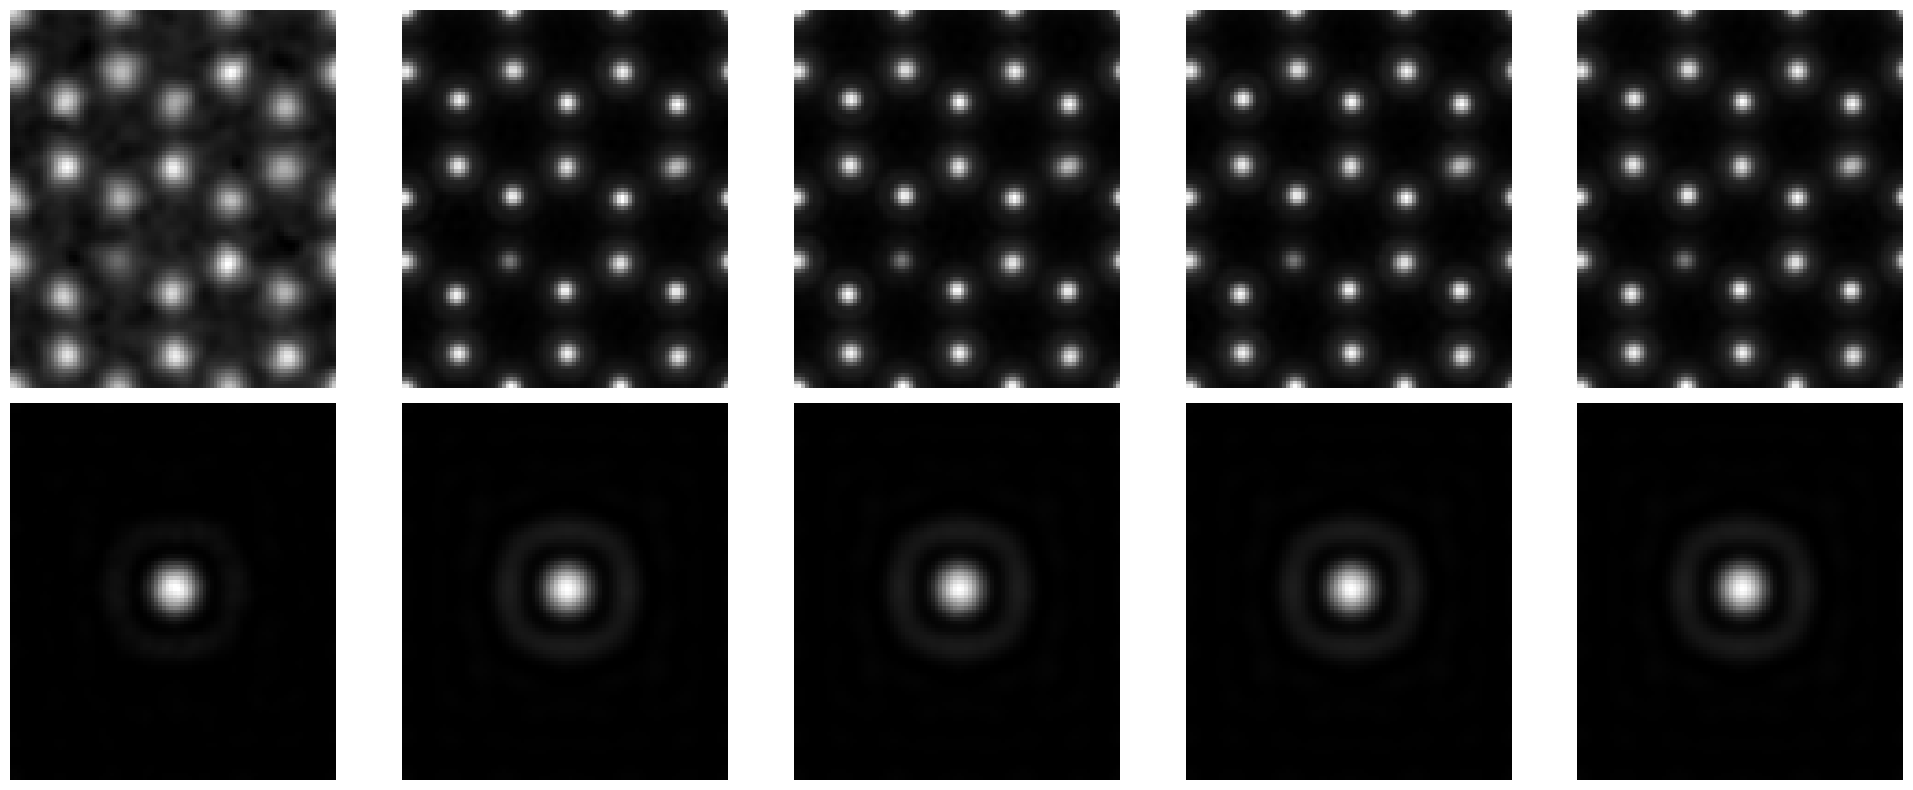

In [27]:
plot_every = 4

fig, axes = plt.subplots(2, int(np.ceil(len(reconstructions_full[0]) / plot_every)), figsize=(20, 8))

for i, j in enumerate(range(0,len(reconstructions_full[0]),plot_every)):
    axes[0,i].imshow(np.angle(reconstructions_full[0][j].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions_full[1][j].array).T ** 2, origin='lower', cmap='gray')
    
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
fig.tight_layout()
plt.show()

In [28]:
probe_guess = Probe(semiangle_cutoff=30, energy=80e3, Cs=1E6, defocus=sch_defocus)
reconstructions_full = epie(band_limited_measurment, probe_guess, maxiter=20, return_iterations=True, fix_com=True, device="gpu")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/672 [00:00<?, ?it/s]

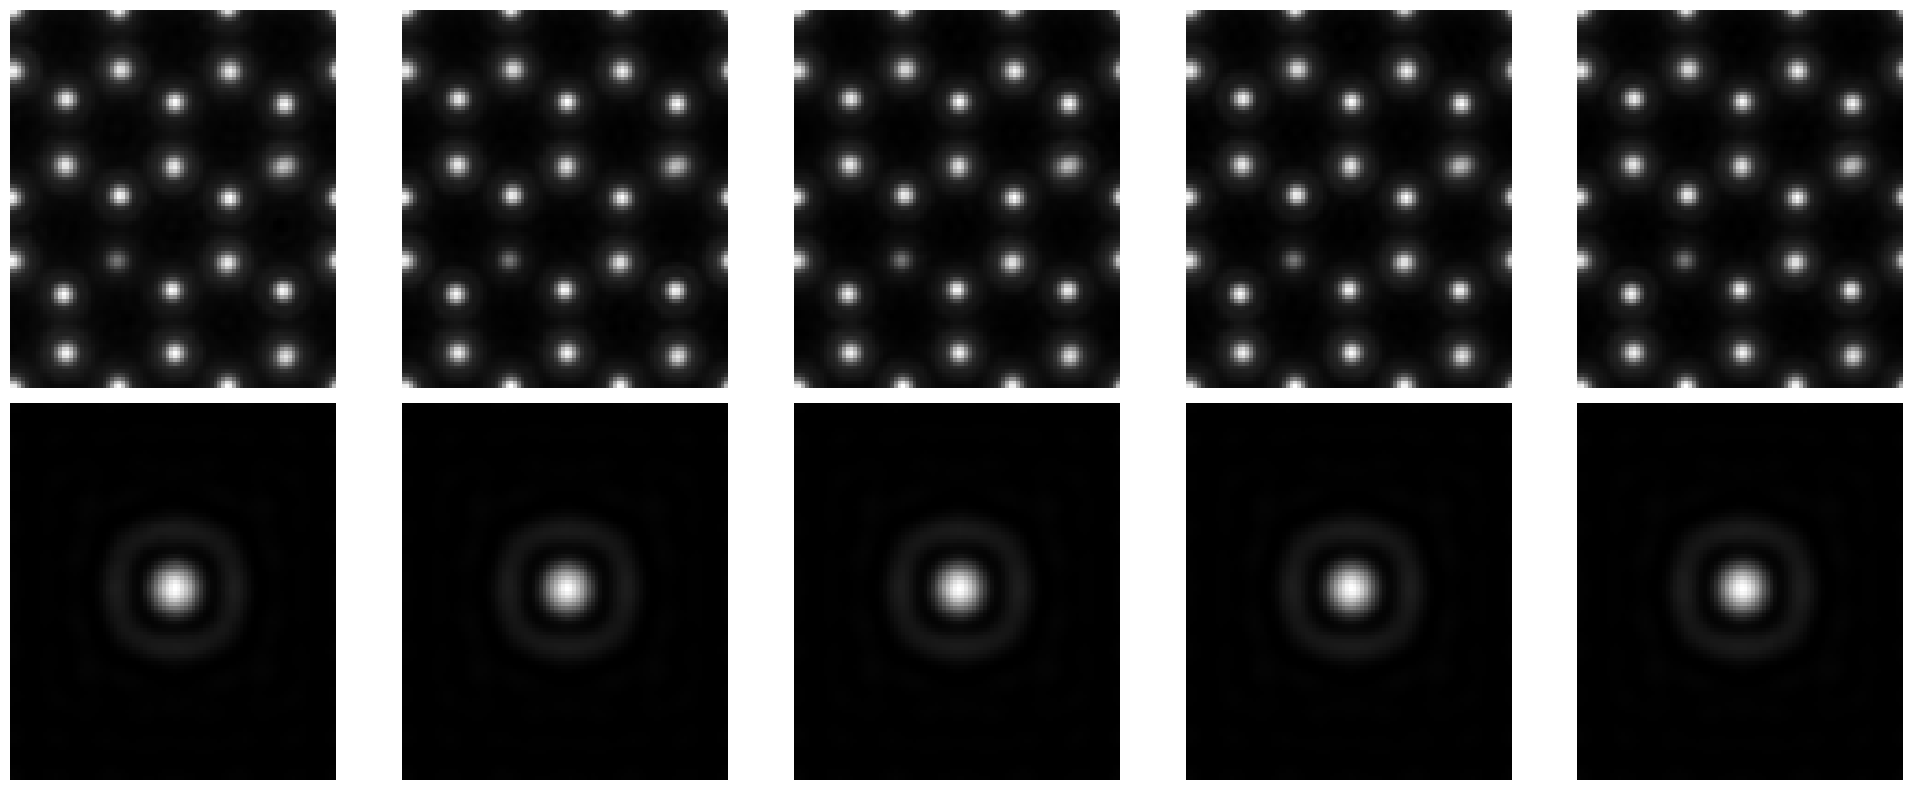

In [29]:
plot_every = 4

fig, axes = plt.subplots(2, int(np.ceil(len(reconstructions_full[0]) / plot_every)), figsize=(20, 8))

for i, j in enumerate(range(0,len(reconstructions_full[0]),plot_every)):
    axes[0,i].imshow(np.angle(reconstructions_full[0][j].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions_full[1][j].array).T ** 2, origin='lower', cmap='gray')
    
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
fig.tight_layout()
plt.show()

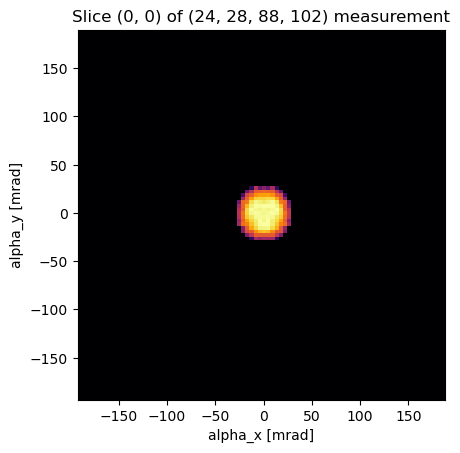

In [30]:
bright_field_measurment = bandlimit(measurement, 30)
bright_field_measurment.show(cmap="inferno", power=0.2)
plt.show()

In [31]:
probe_guess = Probe(semiangle_cutoff=30, energy=80e3)
reconstructions_bright = epie(bright_field_measurment, probe_guess, maxiter=20, return_iterations=True, fix_com=True)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/672 [00:00<?, ?it/s]

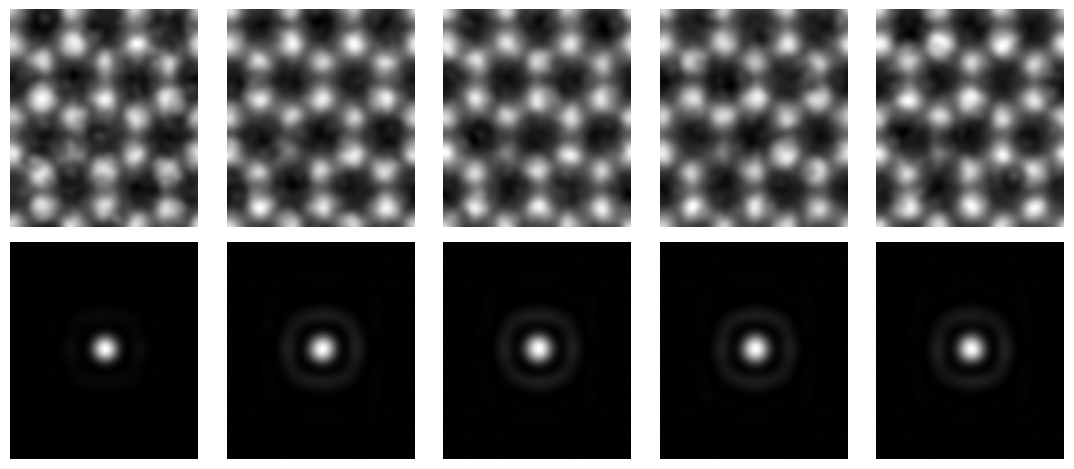

In [32]:
plot_every = 4

fig, axes = plt.subplots(2, int(np.ceil(len(reconstructions_bright[0]) / plot_every)), figsize=(11,4.8))

for i, j in enumerate(range(0, len(reconstructions_bright[0]), plot_every)):
    axes[0,i].imshow(np.angle(reconstructions_bright[0][j].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions_bright[1][j].array).T ** 2, origin='lower', cmap='gray')
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
    
fig.tight_layout()
plt.show()